# 0. Google Colab Setup

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
os.chdir('./drive/MyDrive/NLP MedLM project')

In [4]:
# unzip dataset zipfile
# !unzip './dataset/MedQuAD-master.zip'

In [5]:
# !unzip './dataset/medical-question-answer-data-master.zip'

# 1. Process MedQuAD data

In [ ]:
import xml.etree.ElementTree as ET

import re
from tqdm import tqdm

import pandas as pd

In [ ]:
MED_PATH = './dataset/MedQuAD-master'

file_names = [fn for fn in os.listdir(MED_PATH) if fn[0].isdigit()]

['10_MPlus_ADAM_QA',
 '11_MPlusDrugs_QA',
 '12_MPlusHerbsSupplements_QA',
 '1_CancerGov_QA',
 '2_GARD_QA',
 '3_GHR_QA',
 '4_MPlus_Health_Topics_QA',
 '5_NIDDK_QA',
 '6_NINDS_QA',
 '7_SeniorHealth_QA',
 '8_NHLBI_QA_XML',
 '9_CDC_QA']

In [ ]:
# clean up answers with unwanted tokens and long whitespaces
def clean_up(answer):
  answer = re.sub(' +', ' ', answer)
  answer = answer.replace("Key Points", "")
  answer = answer.replace("\n", "")
  answer = answer.replace("-", "")
  answer = answer.replace("\t", "")
  return answer

def parse_xml(file_name):
  tree = ET.parse(file_name)
  root = tree.getroot()

  # one xml file with only one focus
  try:
    focus = root.find('Focus').text.strip()
  except AttributeError:
    focus = None

  # one xml file may have more than one QA pairs
  qa_pairs = []
  for qa_pair in root.findall('QAPairs/QAPair'):
    question = qa_pair.find('Question').text.strip()
    # may have no answer situation
    try:
      answer = qa_pair.find('Answer').text.strip()
      answer = clean_up(answer)
    except AttributeError:
      answer = None
    qa_pairs.append((question, answer, focus))

  return qa_pairs

In [ ]:
# process all data
def process_files(path):
  processed_data = []
  xml_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.xml')]
  for xml_file in tqdm(xml_files, desc=f"Processing files in {path}"):
    qa_pairs = parse_xml(xml_file)
    processed_data.extend(qa_pairs)

  return processed_data

In [ ]:
def process_folders(root_path):
  data = []
  folders = [f.path for f in os.scandir(root_path) if f.is_dir()]

  for folder in folders:
    processed_data = process_files(folder)
    data.extend(processed_data)

  # convert to pandas dataframe
  df = pd.DataFrame(data, columns=['Question', 'Answer', 'Focus'])
  return df

In [ ]:
med_df = process_folders(MED_PATH)

Processing files in ./dataset/MedQuAD-master/10_MPlus_ADAM_QA: 100%|██████████| 4366/4366 [01:44<00:00, 41.77it/s] 
Processing files in ./dataset/MedQuAD-master/11_MPlusDrugs_QA: 100%|██████████| 1312/1312 [00:24<00:00, 53.65it/s] 
Processing files in ./dataset/MedQuAD-master/12_MPlusHerbsSupplements_QA: 100%|██████████| 99/99 [00:00<00:00, 284.93it/s]
Processing files in ./dataset/MedQuAD-master/1_CancerGov_QA: 100%|██████████| 116/116 [00:00<00:00, 132.39it/s]
Processing files in ./dataset/MedQuAD-master/2_GARD_QA: 100%|██████████| 2685/2685 [00:55<00:00, 48.32it/s] 
Processing files in ./dataset/MedQuAD-master/3_GHR_QA: 100%|██████████| 1086/1086 [00:12<00:00, 86.52it/s] 
Processing files in ./dataset/MedQuAD-master/4_MPlus_Health_Topics_QA: 100%|██████████| 981/981 [00:11<00:00, 82.73it/s] 
Processing files in ./dataset/MedQuAD-master/5_NIDDK_QA: 100%|██████████| 157/157 [00:01<00:00, 139.62it/s]
Processing files in ./dataset/MedQuAD-master/6_NINDS_QA: 100%|██████████| 277/277 [00:

In [ ]:
med_df.head(3)

,Question,Answer,Focus
0,What is (are) A guide to clinical trials for c...,None,A guide to clinical trials for cancer
1,what research (or clinical trials) is being do...,None,A guide to clinical trials for cancer
2,what research (or clinical trials) is being do...,None,A guide to clinical trials for cancer


In [ ]:
# check no answer rows
print(len(med_df))
print(len(med_df[med_df['Answer'].isnull()]))
print(len(med_df[med_df['Answer'] == '']))
df_to_save = med_df[med_df['Answer'].notnull()]

47441
31034
0


In [ ]:
print(len(df_to_save))

16407


In [ ]:
df_to_save.to_csv('./dataset/MedQuAD.csv', index=False)

# 2. Generate insights

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [7]:
m_path = './dataset/MedQuAD.csv'
i_path = './dataset/iCliniq.csv'

m_df = pd.read_csv(m_path)
i_df = pd.read_csv(i_path)

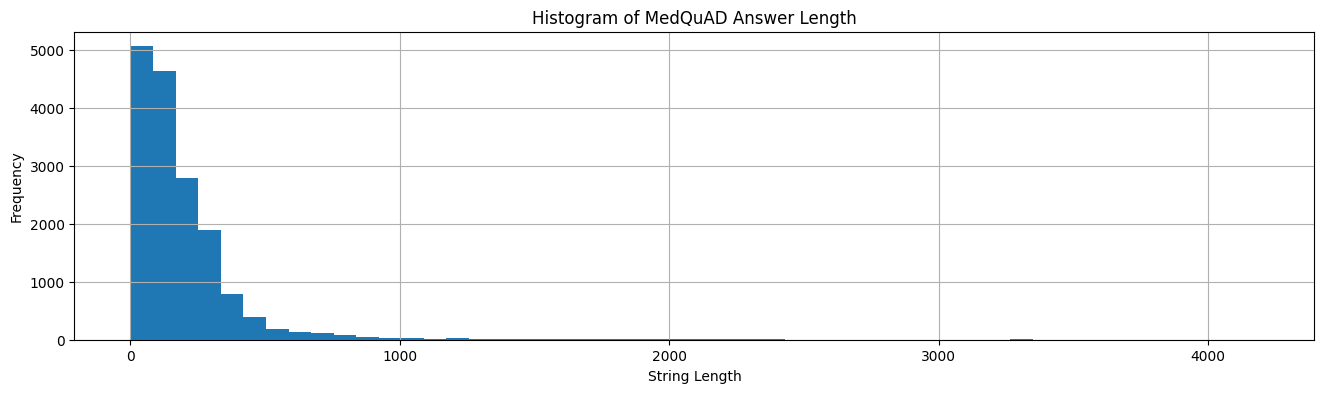

In [18]:
def cnt(row):
  return len(row.split())


m_df['ans_length'] = m_df['Answer'].apply(cnt)
i_df['ans_length'] = i_df['Answer'].apply(cnt)

def dis_plot(df, name):
  plt.figure(figsize = (16,4))
  plt.hist(df['ans_length'], bins=50)
  plt.xlabel('String Length')
  plt.ylabel('Frequency')
  plt.title('Histogram of {} Answer Length'.format(name))
  plt.grid(True)
  plt.show()

dis_plot(m_df, 'MedQuAD')

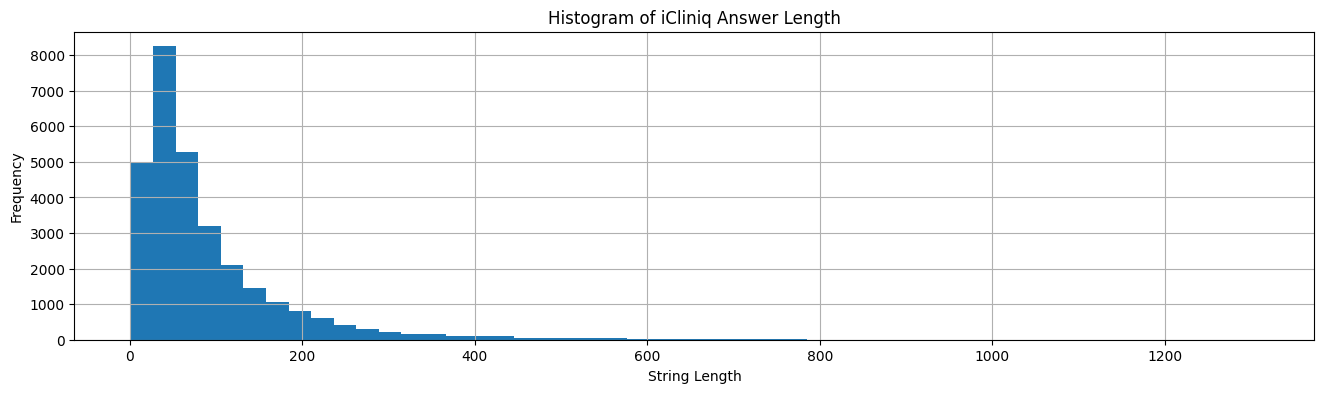

In [19]:
dis_plot(i_df, 'iCliniq')

In [17]:
# check mean and median of each dataset
def check_m(df):
  print("mean:", df['ans_length'].mean())
  print("median: ", df['ans_length'].median())

check_m(m_df)

check_m(i_df)

mean: 197.68031937587614
median:  137.0
mean: 90.99529443398764
median:  60.0


In [26]:
m_df_sample = m_df[m_df['ans_length'] == 30]

m_df_sample.head(3)
m_df['Answer'].iloc[5258]

'How is SCOT deficiency diagnosed? Diagnosis of SCOT deficiency is made in people showing the signs and symptoms of the condition and who have absent or reduced SCOT enzyme activity.'

In [30]:
i_df_sample = i_df[i_df['ans_length'] == 30]

i_df_sample.head(3)
i_df['Question'].iloc[88]

"will brushing my teeth with baking soda and sea salt increase my sodium intake? . i'm on a low sodium diet."